# Email Assistant with Semantic Memory

Let's create an Email Assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

Now, we'll add memory and give the assistant the ability to remember details from previous emails.

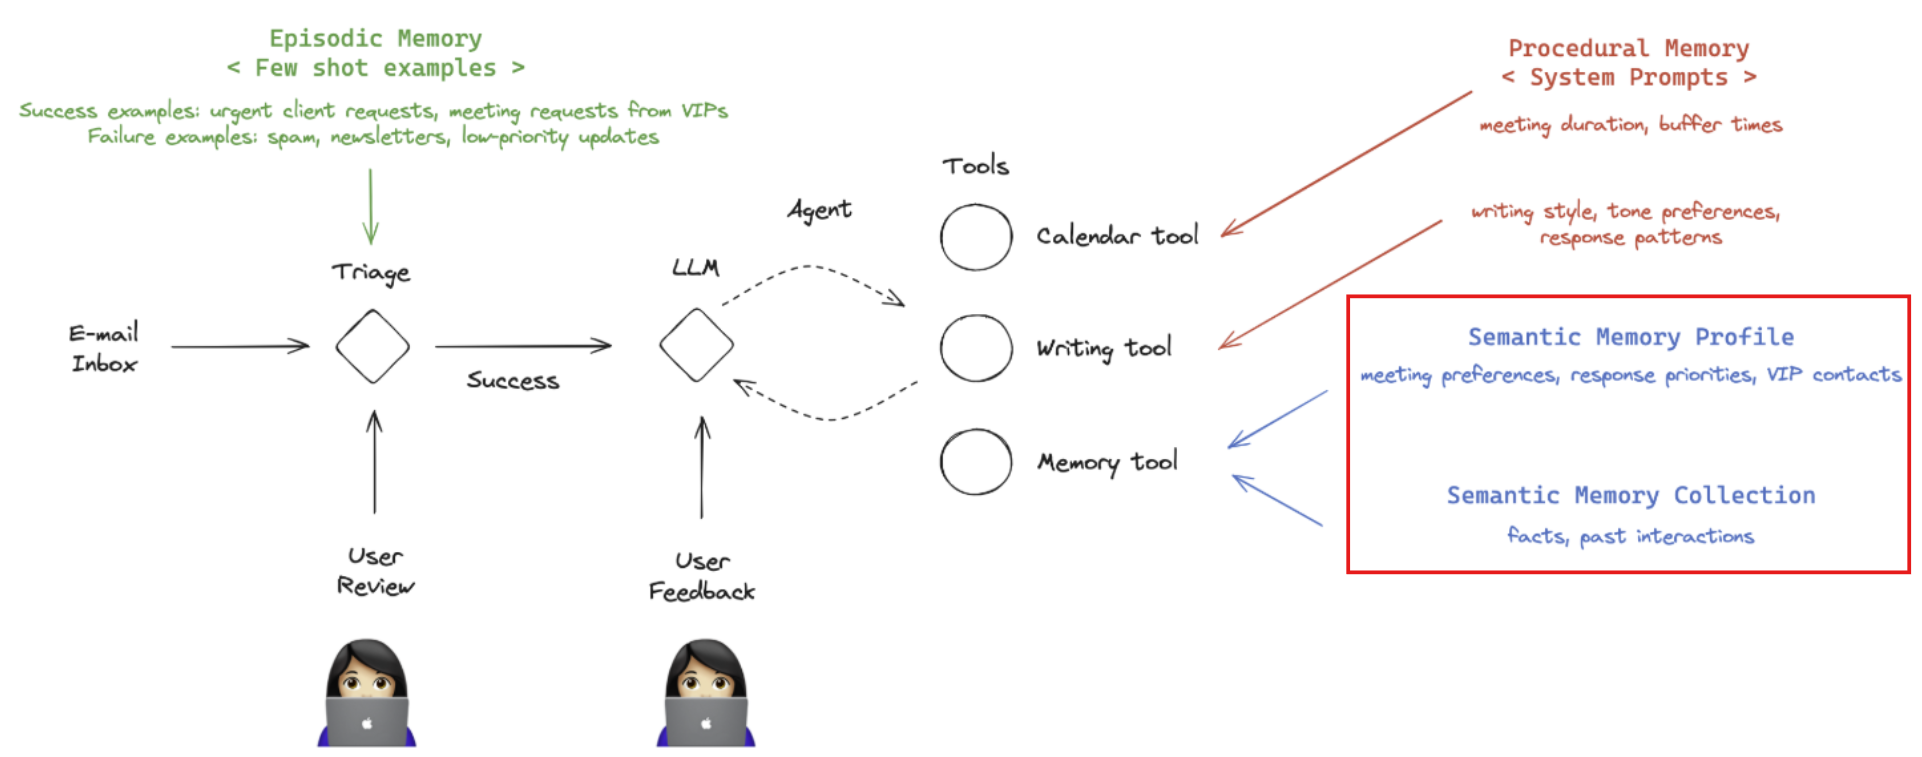

### Load Environment Variables

In [1]:
import os

from dotenv import load_dotenv
load_dotenv()

True

### Create examples for Profile, Prompt and Email

In [2]:
profile = {
    "name": "Sushant",
    "full_name": "Sushant Dhumak",
    "user_profile_background": "Software Development Manager leading a team of 10 developers"
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage Sushant's tasks efficiently."
}

In [4]:
# Example incoming email
email = {
    "from": "John Smith <john.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """

    Hi Sushant,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I'm looking at:
    - /auth/refresh
    - /auth/validate

    Thanks!
    John
    """,
}

### Create Agent -Triage

In [5]:
from pydantic import  BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [6]:
llm = init_chat_model(model="gpt-4o-mini")

In [7]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [8]:
llm_router = llm.with_structured_output(Router)

In [9]:
# Import from local prompt.py file

from prompts import triage_system_prompt, triage_user_prompt

In [10]:
print(triage_system_prompt)
print("-" * 50)
print(triage_user_prompt)


< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Background >
{user_profile_background}. 
</ Background >

< Instructions >

{name} gets lots of emails. Your job is to categorize each email into one of three categories:

1. IGNORE - Emails that are not worth responding to or tracking
2. NOTIFY - Important information that {name} should know about but doesn't require a response
3. RESPOND - Emails that need a direct response from {name}

Classify the below email into one of these categories.

</ Instructions >

< Rules >
Emails that are not worth responding to:
{triage_no}

There are also other things that {name} should know about, but don't require an email response. For these, you should notify {name} (using the `notify` response). Examples of this include:
{triage_notify}

Emails that are worth responding to:
{triage_email}
</ Rules >

< Few shot examples >
{examples}
</ Fe

### Define tools for Agent

In [11]:
from langchain_core.tools import tool

In [12]:
# Tool to write and send email

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""

    # Email content placeholder to be implemented here

    return f"Email sent to {to} with subject '{subject}'"

In [13]:
# Tool for scheduling meeting

@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: str
) -> str:
    """Schedule a Meeting"""

    # Calender check and meeting scheduleing placeholder code to be implment here

    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

In [14]:
# Tool to check Calender for availability

@tool
def check_calender_availability(day: str) -> str:
    """Check calender availability for the given day."""

    # Code to check the calander availability to be implmented here

    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

### Define tools for managing memory

In [15]:
from langgraph.store.memory import InMemoryStore

In [16]:
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)

c:\Users\Sushant.Dhumak\OneDrive - Bentley Systems, Inc\Desktop\AI_Learning\LangGraph\langchain-academy-main\langchain-academy-main\.venv\Lib\site-packages\langgraph\store\base\embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


In [17]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [18]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [19]:
print(manage_memory_tool.name)

manage_memory


In [20]:
print(manage_memory_tool.description)

Create, update, or delete persistent MEMORIES to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [21]:
manage_memory_tool.args

{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Content'},
 'action': {'default': 'create',
  'enum': ['create', 'update', 'delete'],
  'title': 'Action',
  'type': 'string'},
 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Id'}}

In [22]:
print(search_memory_tool.name)

search_memory


In [23]:
print(search_memory_tool.description)

Search your long-term memories for information relevant to your current context.


In [24]:
search_memory_tool.args

{'query': {'title': 'Query', 'type': 'string'},
 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'},
 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'},
 'filter': {'anyOf': [{'type': 'object'}, {'type': 'null'}],
  'default': None,
  'title': 'Filter'}}

### Define prompt for Agent

In [25]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [26]:
def create_prompt(state):
    return [
        {
            "role": "system",
            "content": agent_system_prompt_memory.format(
                instructions = prompt_instructions["agent_instructions"],
                **profile
            )
        }
    ] + state["messages"]

### Define an Agent

In [27]:
from langgraph.prebuilt import create_react_agent

In [28]:
tools= [write_email, schedule_meeting, check_calender_availability, manage_memory_tool, search_memory_tool]

In [29]:
response_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [30]:
config = {
    "configurable": {
        "langgraph_user_id": "Sushant"
        }
}

In [31]:
response = response_agent.invoke(
    {
        "messages" : [
            {
                "role": "user",
                "content": "Prasad and Tushar are my friends."
            }
        ]
    },
    config=config
)

In [32]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Prasad and Tushar are my friends.
================================== Ai Message ==================================
Tool Calls:
  manage_memory (call_OqIgkCRcJ8FdgoyDIVNOPLmN)
 Call ID: call_OqIgkCRcJ8FdgoyDIVNOPLmN
  Args:
    content: Sushant's friends include Prasad and Tushar.
    action: create
  search_memory (call_V2yW1gX4RPDJOEjBFq3FKttw)
 Call ID: call_V2yW1gX4RPDJOEjBFq3FKttw
  Args:
    query: Prasad
  search_memory (call_4USxeeqdi7ns1a7aeGR8b09s)
 Call ID: call_4USxeeqdi7ns1a7aeGR8b09s
  Args:
    query: Tushar
================================= Tool Message =================================
Name: manage_memory

created memory 3b39ac56-a1c3-4289-b9a6-d90617b2ce06
================================= Tool Message =================================
Name: search_memory

[]
================================= Tool Message =================================
Name: search_memory

[]
==========================

In [33]:
response = response_agent.invoke(
    {
        "messages" : [
            {
                "role": "user",
                "content": "Who is Tushar?"
            }
        ]
    },
    config=config
)

In [34]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Who is Tushar?
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_bOO9XqqKELBoG7PONkdoVdGD)
 Call ID: call_bOO9XqqKELBoG7PONkdoVdGD
  Args:
    query: Tushar
================================= Tool Message =================================
Name: search_memory

[{"namespace": ["email_assistant", "Sushant", "collection"], "key": "3b39ac56-a1c3-4289-b9a6-d90617b2ce06", "value": {"content": "Sushant's friends include Prasad and Tushar."}, "created_at": "2025-03-27T08:18:42.864368+00:00", "updated_at": "2025-03-27T08:18:42.864368+00:00", "score": 0.5012533230315852}]
================================== Ai Message ==================================

Tushar is one of Sushant's friends, along with Prasad. If you need more detailed information or context about Tushar, please let me know!


In [35]:
store.list_namespaces()

[('email_assistant', 'Sushant', 'collection')]

In [36]:
store.search(('email_assistant', 'Sushant', 'collection'))

[Item(namespace=['email_assistant', 'Sushant', 'collection'], key='3b39ac56-a1c3-4289-b9a6-d90617b2ce06', value={'content': "Sushant's friends include Prasad and Tushar."}, created_at='2025-03-27T08:18:42.864368+00:00', updated_at='2025-03-27T08:18:42.864368+00:00', score=None)]

In [37]:
store.search(('email_assistant', 'Sushant', 'collection'), query="Prasad")

[Item(namespace=['email_assistant', 'Sushant', 'collection'], key='3b39ac56-a1c3-4289-b9a6-d90617b2ce06', value={'content': "Sushant's friends include Prasad and Tushar."}, created_at='2025-03-27T08:18:42.864368+00:00', updated_at='2025-03-27T08:18:42.864368+00:00', score=0.2872304251110132)]

### Create an Overall Agent

In [38]:
# Define State

from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [39]:
# Graph Imports

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import display, Image

In [40]:
# Triage Node function

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:

    author = state["email_input"]["author"]
    to = state["email_input"]["to"],
    subject = state["email_input"]["subject"],
    email_thread = state["email_input"]["body"]

    system_prompt = triage_system_prompt.format(
        full_name = profile["full_name"],
        name = profile["name"],
        user_profile_background = profile["user_profile_background"],
        triage_no = prompt_instructions["triage_rules"]["ignore"],
        triage_notify = prompt_instructions["triage_rules"]["notify"],
        triage_email = prompt_instructions["triage_rules"]["respond"],
        examples = None
    )

    user_prompt = triage_user_prompt.format(
        author = author,
        to = to,
        subject = subject,
        email_thread = email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    
    return Command(goto=goto, update=update)

In [41]:
# Define the Graph

builder = StateGraph(State)

builder.add_node("triage_router", triage_router)
builder.add_node("response_agent", response_agent)

builder.add_edge(START, "triage_router")

email_agent = builder.compile(store=store)

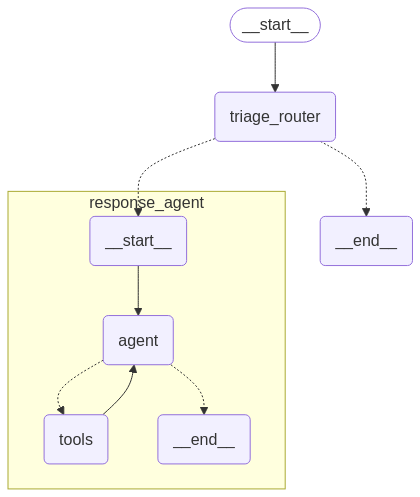

In [42]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [43]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
    
    Hi Sushant,

    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

    Specifically, I'm looking at:
    - /auth/refresh
    - /auth/validate

    Thanks!
    Alice
    """,
}

In [44]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [45]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Sushant Dhumak <sushant.dhumak@company.com>', 'subject': 'Quick question about API documentation', 'body': "\n    \n    Hi Sushant,\n\n    I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\n    Specifically, I'm looking at:\n    - /auth/refresh\n    - /auth/validate\n\n    Thanks!\n    Alice\n    "}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_sDVU8LDAHRHhqTjnwtdBJ0nm)
 Call ID: call_sDVU8LDAHRHhqTjnwtdBJ0nm
  Args:
    to: alice.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for reaching out regarding the API documentation for the new

In [46]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Sushant Dhumak <sushant.dhumak@company.com>",
    "subject": "Follow up",
    "body": """
    Hi Sushant,
    Any update on my previous ask?
    """,
}

In [47]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [48]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Sushant Dhumak <sushant.dhumak@company.com>', 'subject': 'Follow up', 'body': '\n    Hi Sushant,\n    Any update on my previous ask?\n    '}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_qgSTPUQB7u32aZgniuBg7f2A)
 Call ID: call_qgSTPUQB7u32aZgniuBg7f2A
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Follow up
    content: Hi Alice,

Thank you for following up. I am currently working on your request and will provide you with an update shortly. 

Best regards,
Sushant
================================= Tool Message =================================
Name: write_email

Email sent to Alice Smith <alice.smith@company.com> with subject 'Re: Follow up'
================================== Ai Message ==================================

I've sent a re